In [17]:
def model_hyperparam_set(model_id,tuning_type,is_class_reg):
    #model_id=1 --RandomForestClassifier
    #model_id=2 --xgboost
    #model_id=3 --svm
    #model_id=4 --
    
    if model_id==1 and tuning_type=='Grid' and is_class_reg==1:
        param_grid = { "n_estimators"      : [100],
                       "max_depth"         : [5],
                       "max_features"      : [3, 5],                       
                       "min_samples_split" : [2] ,
                        "min_samples_leaf": [1,2,4],
                       "bootstrap": [True],
                       "criterion"         : ['entropy']}
    elif model_id==1 and tuning_type=='Grid' and is_class_reg==2:
        param_grid = { "n_estimators"      : [50],
                       "max_depth"         : [5],
                       "max_features"      : [5],                       
                       "min_samples_split" : [2] ,
                        "min_samples_leaf": [1],
                       "bootstrap": [True],
                       "criterion"         : ['mae']}


    elif model_id==1 and tuning_type=='Random' and is_class_reg==1:
        param_grid = { "n_estimators"      : [100],
                       "max_depth": [3, None],
                       "max_features": sp_randint(1, 11),
                       "min_samples_split": sp_randint(1, 11),
                       "min_samples_leaf": sp_randint(1, 11),
                       "bootstrap": [True, False],
                       "criterion": ["gini", "entropy"]}
    elif model_id==1 and tuning_type=='Random' and is_class_reg==2:
        param_grid = { "n_estimators"      : [100],
                       "max_depth": [3, None],
                       "max_features": sp_randint(1, 11),
                       "min_samples_split": sp_randint(1, 11),
                       "min_samples_leaf": sp_randint(1, 11),
                       "bootstrap": [True, False],
                       "criterion": ["mae"]}

    elif model_id==2 and tuning_type=='Grid' and is_class_reg==2:
        param_grid = { "objective":['binary:logistic'],
                       "n_estimators": [200],
                       "learning_rate": [0.05],
                       "max_depth": [8],
                       "subsample": [0.80],
                       "colsample_bytree": [0.7]
                       #,"alpha":[10]
                         }

    elif model_id==2 and tuning_type=='Random':
            param_grid = { "n_estimators": [100,200,400],
                           "learning_rate": [0.01,0.05,0.1],
                           "max_depth": [5,None],
                           "subsample": sp_randint(0.60,0.90),
                           "colsample_bytree": sp_randint(0.60,0.90)}
    elif model_id==3 and tuning_type=='Grid' and is_class_reg==2:
        param_grid = {'num_leaves': [10],
                      'reg_alpha': [0.1],
                      'min_data_in_leaf': [10],
                      'lambda_l1': [0],
                      'lambda_l2': [0]
    }



    return param_grid        

def model_training(model,tuning_type,param_grid,traindata,target,cv_kfold,score_criterion,n_iterations):
    #target_index=traindata.columns.get_loc(target)
    x_var=list(traindata.columns)
    x_var.remove(target)

    #model = RandomForestRegressor()
    if tuning_type=='Grid':
        grid = GridSearchCV(estimator=model, param_grid=param_grid,cv=cv_kfold,verbose=True)
    elif tuning_type=='Random':
        grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,n_iter=n_iterations,cv=cv_kfold,scoring=score_criterion)   
    
    grid.fit(traindata[x_var], traindata[target])
    #print(grid)
    # summarize the results of the random parameter search
    #print(grid.best_score_)
    #print(grid.best_params_)    
    #print(grid.best_estimator_)
    return grid 


In [18]:
import statsmodels.api as sm
from sklearn import preprocessing
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgbm
#import sklearn
#import statsmodels.api as sm
from catboost import CatBoostRegressor as cab 
from sklearn.model_selection import cross_val_score,GridSearchCV,RandomizedSearchCV,KFold
from sklearn.metrics import r2_score,mean_squared_error
from sklearn import metrics
from sklearn.impute import SimpleImputer
from matplotlib import pyplot
import seaborn as sns

In [19]:
#model=CatBoostRegressor(iterations=50, depth=3, learning_rate=0.1, loss_function='RMSE')
#model.fit(X_train, y_train,cat_features=categorical_features_indices,eval_set=(X_validation, y_validation),plot=True)
jhmobTrainData=pd.read_csv('train_Wc8LBpr.csv',sep=',',header=0)
jhmobTestData=pd.read_csv('test_VsU9xXK.csv',sep=',',header=0)


In [20]:
jhmobTestData['Surge_Pricing_Type']=-99999
jhmobData = jhmobTrainData.append(jhmobTestData) #merge train & test data for further processing

In [21]:
jhmobData.head(5)
#jhmobData['Surge_Pricing_Type'].value_counts()
#jhmobTestData.shape[0]

,Trip_ID,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender,Surge_Pricing_Type
0,T0005689460,6.77,B,1.0,2.42769,A,A,3.90500,0,40.0,46,60,Female,2
1,T0005689461,29.47,B,10.0,2.78245,B,A,3.45000,0,38.0,56,78,Male,2
2,T0005689464,41.58,NaN,10.0,NaN,NaN,E,3.50125,2,NaN,56,77,Male,2
3,T0005689465,61.56,C,10.0,NaN,NaN,A,3.45375,0,NaN,52,74,Male,3
4,T0005689467,54.95,C,10.0,3.03453,B,A,3.40250,4,51.0,49,102,Male,2


In [22]:
jhmobData.shape , jhmobTrainData.shape, jhmobTestData.shape

((219057, 14), (131662, 14), (87395, 14))

In [23]:
jhmobData.dtypes
#jhmobData['company_size'].unique()

Trip_ID                         object
Trip_Distance                  float64
Type_of_Cab                     object
Customer_Since_Months          float64
Life_Style_Index               float64
Confidence_Life_Style_Index     object
Destination_Type                object
Customer_Rating                float64
Cancellation_Last_1Month         int64
Var1                           float64
Var2                             int64
Var3                             int64
Gender                          object
Surge_Pricing_Type               int64
dtype: object

In [24]:
#jhmobData[['gender','city','education_level','company_size','company_type','experience','last_new_job']].describe()
jhmobData['Destination_Type'].value_counts()
jhmobData['Customer_Since_Months'].describe()
#jhmobData['Life_Style_Index'].mean()

count    209171.000000
mean          6.006048
std           3.626891
min           0.000000
25%           3.000000
50%           6.000000
75%          10.000000
max          10.000000
Name: Customer_Since_Months, dtype: float64

In [25]:
#missing values
jhmobData.isnull().sum()

#checking target imbalance
#jhmobTrainData[jhmobTrainData['target']==1]['target'].count()/jhmobTrainData.shape[0]
#m = jhmobData['enrolled_university'].mode().values[0]
#print(m)
#jhmobData['enrolled_university'].fillna(m, inplace=True)


Trip_ID                             0
Trip_Distance                       0
Type_of_Cab                     33368
Customer_Since_Months            9886
Life_Style_Index                33520
Confidence_Life_Style_Index     33520
Destination_Type                    0
Customer_Rating                     0
Cancellation_Last_1Month            0
Var1                           117819
Var2                                0
Var3                                0
Gender                              0
Surge_Pricing_Type                  0
dtype: int64

In [31]:
def impute_missing(df,cols,impute_by):
    
    #df[cols].apply(lambda x: x.fillna(x.mode().values[0], inplace=True))
    for x in cols:
        #mode = '99999'
        if impute_by == 'mean':
            df[x].fillna(df[x].mean(), inplace=True)
        else:
            df[x].fillna(impute_by, inplace=True)

    return df
    

In [32]:
#start feature engineering
def feature_engg(df):
    
    label_encoder = preprocessing.LabelEncoder() 
    df['Type_of_Cab_Le']= label_encoder.fit_transform(df['Type_of_Cab']) 
    df['Confidence_Life_Style_Index_Le']= label_encoder.fit_transform(df['Confidence_Life_Style_Index'])
    df['Destination_Type_Le']= label_encoder.fit_transform(df['Destination_Type'])
    df['Gender_Le']= label_encoder.fit_transform(df['Gender'])
    
    #dfAgg = df[df['target']==1].groupby('gender').agg(genderPosCount=('target','count'))
    #df=pd.merge(df,dfAgg,on='gender',how='inner')
    #dfAgg = df[df['target']==0].groupby('gender').agg(genderNegCount=('target','count'))
    #df=pd.merge(df,dfAgg,on='gender',how='inner')
    #df['genderTR'] = df['genderPosCount']/df['genderNegCount']

    #0.79    
    conditions=[(df['Cancellation_Last_1Month']==0),
                (df['Cancellation_Last_1Month']>0)&(df['Cancellation_Last_1Month']<=2)
               ,(df['Cancellation_Last_1Month']>2)]
    choices=[1,2,3]
    df['Cancellation_Last_1Month_Bins']=np.select(conditions,choices,default=0)
    #df['city_dev_index_bins'] = df['city_dev_index_bins'].astype('category')
    #df=cat_to_one_hot_encode(df,['city_dev_index_bins'])
    
    
    #conditions=[(df['training_hours']>=150)&(df['relevent_experience']=='No relevent experience')]
    #choices=[1]
    #df['training_relExp_Inter']=np.select(conditions,choices,default=0)
    dfAgg = df[df['Surge_Pricing_Type']==0].groupby('Destination_Type')
    agg(DestTypeClass0Count=('Surge_Pricing_Type','count'))
    df=pd.merge(df,dfAgg,on='Destination_Type',how='inner')
    
    dfAgg = df[df['Surge_Pricing_Type']==1].groupby('Destination_Type').agg(DestTypeClass1Count=('Surge_Pricing_Type','count'))
    df=pd.merge(df,dfAgg,on='Destination_Type',how='inner')
    
    dfAgg = df[df['Surge_Pricing_Type']==2].groupby('Destination_Type').agg(DestTypeClass2Count=('Surge_Pricing_Type','count'))
    df=pd.merge(df,dfAgg,on='Destination_Type',how='inner')
    
    df['Destination_TypeClass01TR'] = df['DestTypeClass0Count']/df['DestTypeClass1Count']
    df['Destination_TypeClass02TR'] = df['DestTypeClass0Count']/df['DestTypeClass2Count']
    df['Destination_TypeClass12TR'] = df['DestTypeClass1Count']/df['DestTypeClass2Count']

    dfAgg = df.groupby('Destination_Type').agg(DestTypeCancelSum=('Cancellation_Last_1Month','sum'))
    df=pd.merge(df,dfAgg,on='Destination_Type',how='inner')

    
    df=cat_to_one_hot_encode(df,['Type_of_Cab'])
    df=cat_to_one_hot_encode(df,['Confidence_Life_Style_Index'])
    df=cat_to_one_hot_encode(df,['Destination_Type'])
    df=cat_to_one_hot_encode(df,['Gender'])
    
    df['Var1_Smooth']=np.sqrt(df['Var1'])
    df['Var2_by_Var3']=df['Var2']/df['Var3']
    
    df['Cancel_to_CusDur_Ratio']=df['Cancellation_Last_1Month']/df['Customer_Since_Months'].replace(0,0.01)
    df['Rating_to_CusDur_Ratio']=df['Customer_Rating']/df['Customer_Since_Months'].replace(0,0.01)
    
    #df['company_size_Le'] = df['company_size_Le'].astype('category')
    #df=cat_to_one_hot_encode(df,['company_size_Le'])
    #df['company_type_Le'] = df['company_type_Le'].astype('category')
    #df=cat_to_one_hot_encode(df,['company_type_Le'])
    
     
        
    #df['city_Le'] = df['city_Le'].astype('category')
    #df=cat_to_one_hot_encode(df,['city_Le'])    
    
       
    return df

def cat_to_one_hot_encode(traindata,cat_column_list):
    
    for i in range(0,len(cat_column_list)):
        if traindata[cat_column_list[i]].dtypes == 'category':        
            traindata=pd.get_dummies(traindata,columns=[cat_column_list[i]],drop_first=False)
            #cat_column_one_hot.columns=[cat_column_list[i]+'_'+str(col) for col in cat_column_one_hot.columns]
            #traindata=traindata.merge(cat_column_one_hot,left_index=True,right_index=True)
            #traindata=traindata.drop(cat_column_list[i],axis=1)
    return traindata

#end feature engineering

In [33]:
#jhmobData['roll']=jhmobData.rolling(3,on='electricity_consumption').sum()
#conditions=[(jhmobData['electricity_consumption']==-99999)]
#choices=[0]
#jhmobData['elec_cons']=np.select(conditions,choices,default=jhmobData['electricity_consumption'])

#jhmobData['roll']=jhmobData['elec_cons'].rolling(24*14).sum()

In [34]:
#EDA
jhmobData[['Var1','Var1_Smooth','Var2','Var3','Life_Style_Index','Customer_Since_Months','Cancellation_Last_1Month']].describe()
#jhmobData.isnull().sum()

KeyError: "['Var1_Smooth'] not in index"

In [13]:
#jhmobData[jhmobData['electricity_consumption']==-99999].shape
#start data prep
#jhmobData.set_index(['enrollee_id'])
#jhmobData.isnull().sum()
xCatCols = ['Type_of_Cab','Confidence_Life_Style_Index','Destination_Type','Gender']
xContCols = ['Trip_Distance','Customer_Since_Months','Life_Style_Index','Customer_Rating','Cancellation_Last_1Month']
xContCols = xContCols + ['Var1','Var2','Var3']

jhmobData = impute_missing(jhmobData,['Var1'],0)
jhmobData = impute_missing(jhmobData,[x for x in xContCols if x not in['Var1']],'mean')
jhmobData = impute_missing(jhmobData,xCatCols,'99999')

jhmobData[xCatCols] = jhmobData[xCatCols].astype('category')

jhmobData = feature_engg(jhmobData)


# def impute_missing(df,cols,impute_by):
    
#     #df[cols].apply(lambda x: x.fillna(x.mode().values[0], inplace=True))
#     for x in cols:
#         #mode = '99999'
#         if impute_by == 'mean':
#             df[x].fillna(df[x].mean(), inplace=True)
#         else:
#             df[x].fillna(impute_by, inplace=True)

#     return df

#jhmobData=jhmobData.drop(['Date'],axis=1)
#end data prep



NameError: name 'feature_engg' is not defined

In [ ]:
[x for x in xContCols if x not in['Var1']]

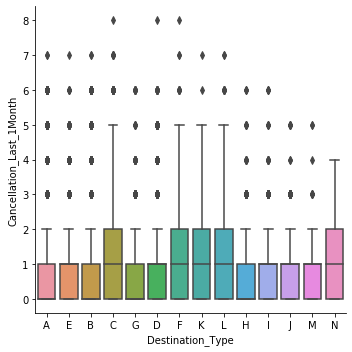

In [14]:
sns.catplot(x="Destination_Type", y="Cancellation_Last_1Month", kind="box", data=jhmobTrainData);

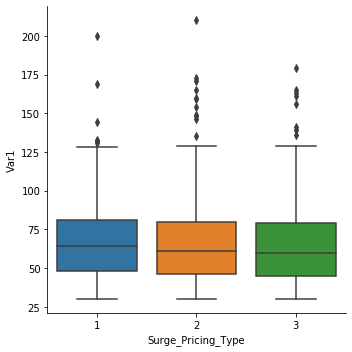

In [15]:
sns.catplot(x="Surge_Pricing_Type", y="Var1", kind="box", data=jhmobTrainData);

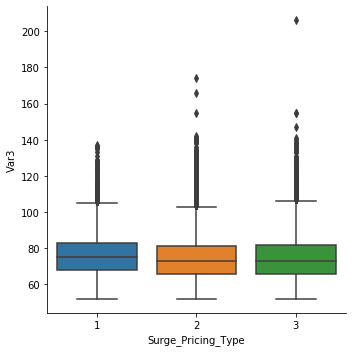

In [16]:
sns.catplot(x="Surge_Pricing_Type", y="Var3", kind="box", data=jhmobTrainData);

In [136]:
#jhmobData['company_size_Le'].value_counts()
jhmobData.head(5)
jhmobData.columns
#jhmobData.sort_values(by=['enrollee_id'])
#jhmobData[jhmobData['target']!=-99999].groupby(['company_size','target']).agg({'target':['count']})

Index(['Trip_ID', 'Trip_Distance', 'Customer_Since_Months', 'Life_Style_Index',
       'Customer_Rating', 'Cancellation_Last_1Month', 'Var1', 'Var2', 'Var3',
       'Surge_Pricing_Type', 'Type_of_Cab_Le',
       'Confidence_Life_Style_Index_Le', 'Destination_Type_Le', 'Gender_Le',
       'Cancellation_Last_1Month_Bins', 'DestTypeClass0Count',
       'DestTypeClass1Count', 'DestTypeClass2Count',
       'Destination_TypeClass01TR', 'Destination_TypeClass02TR',
       'Destination_TypeClass12TR', 'DestTypeCancelSum', 'Type_of_Cab_99999',
       'Type_of_Cab_A', 'Type_of_Cab_B', 'Type_of_Cab_C', 'Type_of_Cab_D',
       'Type_of_Cab_E', 'Confidence_Life_Style_Index_99999',
       'Confidence_Life_Style_Index_A', 'Confidence_Life_Style_Index_B',
       'Confidence_Life_Style_Index_C', 'Destination_Type_A',
       'Destination_Type_B', 'Destination_Type_C', 'Destination_Type_D',
       'Destination_Type_E', 'Destination_Type_F', 'Destination_Type_G',
       'Destination_Type_H', 'Destination_

In [156]:
X_cols = ['Trip_Distance','Customer_Since_Months','Life_Style_Index','Customer_Rating','Cancellation_Last_1Month'
         ,'Var1','Var2','Var3','Type_of_Cab_99999','Type_of_Cab_A','Type_of_Cab_B','Type_of_Cab_C'
         ,'Type_of_Cab_D','Type_of_Cab_E']


X_cols = X_cols + ['Confidence_Life_Style_Index_99999','Confidence_Life_Style_Index_A','Confidence_Life_Style_Index_B'
                  ,'Confidence_Life_Style_Index_C']
X_cols = X_cols + ['Destination_Type_A','Destination_Type_B','Destination_Type_C','Destination_Type_D','Destination_Type_E'
                  ,'Destination_Type_F','Destination_Type_G','Destination_Type_H','Destination_Type_I','Destination_Type_J'
                   ,'Destination_Type_K','Destination_Type_L','Destination_Type_M','Destination_Type_N']

X_cols = X_cols +['Gender_Female','Gender_Male']
X_cols = X_cols +['Cancellation_Last_1Month_Bins','Var2_by_Var3']
#X_cols = X_cols +['Destination_TypeClass12TR']
#X_cols = X_cols +['DestTypeCancelSum','Cancel_to_CusDur_Ratio','Rating_to_CusDur_Ratio']
X_cols = X_cols +['Surge_Pricing_Type']
X_cols1=[x for x in X_cols if x!='Surge_Pricing_Type']
jhmobTrainData=jhmobData[jhmobData['Surge_Pricing_Type']!=-99999]
jhmobTestData=jhmobData[jhmobData['Surge_Pricing_Type']==-99999]
jhmobTrainData[X_cols].head(20)

,Trip_Distance,Customer_Since_Months,Life_Style_Index,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Type_of_Cab_99999,Type_of_Cab_A,...,Destination_Type_J,Destination_Type_K,Destination_Type_L,Destination_Type_M,Destination_Type_N,Gender_Female,Gender_Male,Cancellation_Last_1Month_Bins,Var2_by_Var3,Surge_Pricing_Type
0,6.77,1.000000,2.427690,3.90500,0,40.0,46,60,0,0,...,0,0,0,0,0,1,0,1,0.766667,2
1,29.47,10.000000,2.782450,3.45000,0,38.0,56,78,0,0,...,0,0,0,0,0,0,1,1,0.717949,2
2,61.56,10.000000,2.802594,3.45375,0,0.0,52,74,0,0,...,0,0,0,0,0,0,1,1,0.702703,3
3,54.95,10.000000,3.034530,3.40250,4,51.0,49,102,0,0,...,0,0,0,0,0,0,1,3,0.480392,2
4,19.06,10.000000,2.802594,2.59750,1,72.0,63,91,0,0,...,0,0,0,0,0,0,1,2,0.692308,3
5,18.44,2.000000,2.818710,3.58250,0,103.0,46,63,0,0,...,0,0,0,0,0,0,1,1,0.730159,2
6,106.80,3.000000,2.802594,3.14625,0,0.0,58,92,0,0,...,0,0,0,0,0,0,1,1,0.630435,2
7,107.19,5.000000,3.044670,2.44375,1,0.0,58,83,0,0,...,0,0,0,0,0,0,1,2,0.698795,3
8,31.16,6.006048,2.691700,2.14750,0,0.0,53,90,0,0,...,0,0,0,0,0,1,0,1,0.588889,1
9,83.53,0.000000,2.806580,2.07625,0,0.0,51,75,0,0,...,0,0,0,0,0,0,1,1,0.680000,2


In [157]:
jhmobData.columns
print(len(X_cols1))
#jhmobTrainData['target'].value_counts()
print((X_cols1))

36
['Trip_Distance', 'Customer_Since_Months', 'Life_Style_Index', 'Customer_Rating', 'Cancellation_Last_1Month', 'Var1', 'Var2', 'Var3', 'Type_of_Cab_99999', 'Type_of_Cab_A', 'Type_of_Cab_B', 'Type_of_Cab_C', 'Type_of_Cab_D', 'Type_of_Cab_E', 'Confidence_Life_Style_Index_99999', 'Confidence_Life_Style_Index_A', 'Confidence_Life_Style_Index_B', 'Confidence_Life_Style_Index_C', 'Destination_Type_A', 'Destination_Type_B', 'Destination_Type_C', 'Destination_Type_D', 'Destination_Type_E', 'Destination_Type_F', 'Destination_Type_G', 'Destination_Type_H', 'Destination_Type_I', 'Destination_Type_J', 'Destination_Type_K', 'Destination_Type_L', 'Destination_Type_M', 'Destination_Type_N', 'Gender_Female', 'Gender_Male', 'Cancellation_Last_1Month_Bins', 'Var2_by_Var3']


In [43]:
jhmobTrainData[X_cols1]

,Trip_Distance,Customer_Since_Months,Life_Style_Index,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Type_of_Cab_99999,Type_of_Cab_A,...,Destination_Type_G,Destination_Type_H,Destination_Type_I,Destination_Type_J,Destination_Type_K,Destination_Type_L,Destination_Type_M,Destination_Type_N,Gender_Female,Gender_Male
0,6.77,1.0,2.427690,3.90500,0,40.0,46,60,0,0,...,0,0,0,0,0,0,0,0,1,0
1,29.47,10.0,2.782450,3.45000,0,38.0,56,78,0,0,...,0,0,0,0,0,0,0,0,0,1
2,41.58,10.0,2.802594,3.50125,2,0.0,56,77,1,0,...,0,0,0,0,0,0,0,0,0,1
3,61.56,10.0,2.802594,3.45375,0,0.0,52,74,0,0,...,0,0,0,0,0,0,0,0,0,1
4,54.95,10.0,3.034530,3.40250,4,51.0,49,102,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131657,11.72,1.0,2.742290,3.28500,0,61.0,47,76,0,0,...,0,0,0,0,0,0,0,0,0,1
131658,74.81,7.0,2.810590,0.44500,0,0.0,63,88,0,0,...,0,0,0,0,0,0,0,0,0,1
131659,40.17,10.0,2.995650,3.33625,0,0.0,48,75,0,0,...,0,0,0,0,0,0,0,0,1,0
131660,46.88,4.0,3.047440,4.15750,1,47.0,54,79,0,0,...,0,0,0,0,0,0,0,0,0,1


In [160]:
jhmobTrainData['Surge_Pricing_Type'].value_counts()

1    56728
2    47720
0    27214
Name: Surge_Pricing_Type, dtype: int64

In [159]:
jhmobTrainData['Surge_Pricing_Type'].value_counts()
conditions=[(jhmobTrainData['Surge_Pricing_Type']==1),(jhmobTrainData['Surge_Pricing_Type']==2)
,(jhmobTrainData['Surge_Pricing_Type']==3)]
choices=[0,1,2]
jhmobTrainData['Surge_Pricing_Type']=np.select(conditions,choices,default=4)

C:\Users\Mithilesh\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [144]:
#xgboost cross validation
#iter = 32 is best as of now
params = {
    'max_depth':8,
    'min_child_weight': 1,
    'eta':0.05,
    'subsample': 0.80,
    'colsample_bytree': 0.50,
    'objective':'multi:softprob',
    'eval_metric': 'merror',
    'num_boost_round': 300,
    'gamma':0,
    'num_class':3
    
}
d_train = xgb.DMatrix(jhmobTrainData[X_cols1], label=jhmobTrainData['Surge_Pricing_Type'])

cv_results = xgb.cv(
    params,
    d_train,
    num_boost_round=300,
    seed=42,
    nfold=5,
    metrics={'merror'},
    early_stopping_rounds=300
    #num_classes=3
)
cv_results
#model training




,train-merror-mean,train-merror-std,test-merror-mean,test-merror-std
0,0.317776,0.010190,0.328189,0.010917
1,0.312824,0.016864,0.323328,0.019273
2,0.303531,0.003154,0.312794,0.006058
3,0.301085,0.002368,0.311775,0.003986
4,0.300553,0.003436,0.310788,0.006035
...,...,...,...,...
295,0.243115,0.001087,0.294611,0.003436
296,0.242965,0.001109,0.294770,0.003491
297,0.242830,0.001146,0.294793,0.003546
298,0.242678,0.001115,0.294755,0.003636


In [ ]:
xgb_model=xgb.XGBClassifier(learning_rate =0.05, n_estimators=300, max_depth=8,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.5,
 objective= 'multi:softprob',eval_metric='merror', nthread=4, scale_pos_weight=1, seed=42)
xgb_model.fit(jhmobTrainData[X_cols1],jhmobTrainData['Surge_Pricing_Type'])



C:\Users\Mithilesh\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


              precision    recall  f1-score   support

           0       0.80      0.61      0.69     27214
           1       0.71      0.83      0.77     56728
           2       0.78      0.73      0.76     47720

    accuracy                           0.75    131662
   macro avg       0.76      0.72      0.74    131662
weighted avg       0.76      0.75      0.75    131662

[0.00433411 0.00187568 0.00343405 0.00325663 0.00735046 0.00426804
 0.00208367 0.00268392 0.0250416  0.27495387 0.17353961 0.0710944
 0.22991988 0.09589164 0.00199612 0.01385721 0.00966997 0.00302778
 0.00276001 0.00797945 0.00186533 0.00419676 0.00230558 0.00307915
 0.00249476 0.00184034 0.00236637 0.00226649 0.00210769 0.00254985
 0.00200959 0.00268972 0.0016279  0.00165704 0.00957855 0.00302841
 0.00582873 0.00374717 0.00309925 0.00264322]


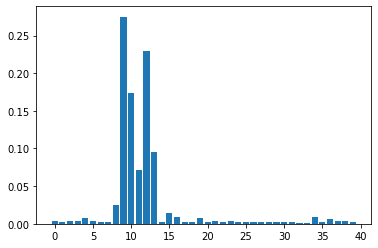

In [146]:
pred = xgb_model.predict_proba(jhmobTrainData[X_cols1])
#print(metrics.classification_report(jhmobTrainData['Surge_Pricing_Type'], pred))




pred_labels = np.argmax(pred, axis=1)

jhmobTrainData['Surge_Pricing_Type_Pred']= pred_labels


print(metrics.classification_report(jhmobTrainData['Surge_Pricing_Type'], jhmobTrainData['Surge_Pricing_Type_Pred']))

print(xgb_model.feature_importances_)
pyplot.bar(range(len(xgb_model.feature_importances_)), xgb_model.feature_importances_)
pyplot.show()


In [173]:
pred[:,1]

array([0.2511915 , 0.2912449 , 0.28796837, ..., 0.34060544, 0.2881501 ,
       0.36035523], dtype=float32)

In [147]:
categoricals = [x for x in X_cols1 if x not in ['Trip_Distance','Customer_Since_Months','Life_Style_Index','Customer_Rating','Cancellation_Last_1Month'
         ,'Var1','Var2','Var3','Cancellation_Last_1Month_Bins']]
indexes_of_categories = [jhmobTrainData.columns.get_loc(col) for col in categoricals]

gkf = KFold(n_splits=5, shuffle=True, random_state=42).split(X=jhmobTrainData[X_cols1], y=jhmobTrainData['Surge_Pricing_Type'])

param_grid = {
    'num_leaves': [50],
    'max_depth':[5],
    'reg_alpha': [0],
    'min_data_in_leaf': [10],
    'lambda_l1': [0],
    'lambda_l2': [0],
    'reg_alpha': [0],
    'reg_lambda': [0],
    'learning_rate': [0.05],
    'objective': ['multiclass'],
    'num_class': [3]
    }

params = {}
params['max_bin'] = 10
params['learning_rate'] = 0.03 # shrinkage_rate
params['boosting_type'] = 'gbdt'
params['objective'] = 'multi:softprob'
#params['metric'] = 'binary_error'          # or 'mae'
params['sub_feature'] = 0.50      # feature_fraction 
params['bagging_fraction'] = 0.80 # sub_row
params['bagging_freq'] = 40
params['num_leaves'] = 512        # num_leaf
params['min_data'] = 20         # min_data_in_leaf
#params['min_hessian'] = 0.05     # min_sum_hessian_in_leaf
params['verbose'] = 0

#cross validation
d_train = lgbm.Dataset(jhmobTrainData[X_cols1], label=jhmobTrainData['Surge_Pricing_Type'])

cv_results = lgbm.cv(param_grid,d_train, num_boost_round=300, nfold=5, 
                    verbose_eval=1, early_stopping_rounds=500,metrics='multi_error')
#



[1]	cv_agg's multi_error: 0.569139 + 1.45445e-05
[2]	cv_agg's multi_error: 0.541812 + 0.00645835
[3]	cv_agg's multi_error: 0.430086 + 0.002553
[4]	cv_agg's multi_error: 0.418321 + 0.00281346
[5]	cv_agg's multi_error: 0.417273 + 0.00230259
[6]	cv_agg's multi_error: 0.414972 + 0.00172522
[7]	cv_agg's multi_error: 0.400389 + 0.00479153
[8]	cv_agg's multi_error: 0.360127 + 0.00539383
[9]	cv_agg's multi_error: 0.332875 + 0.00312186
[10]	cv_agg's multi_error: 0.325219 + 0.00227647
[11]	cv_agg's multi_error: 0.321065 + 0.00195289
[12]	cv_agg's multi_error: 0.319348 + 0.00222426
[13]	cv_agg's multi_error: 0.318254 + 0.00212555
[14]	cv_agg's multi_error: 0.317191 + 0.00162618
[15]	cv_agg's multi_error: 0.316644 + 0.00127069
[16]	cv_agg's multi_error: 0.315756 + 0.00124972
[17]	cv_agg's multi_error: 0.315323 + 0.00121002
[18]	cv_agg's multi_error: 0.31492 + 0.0015663
[19]	cv_agg's multi_error: 0.314563 + 0.001874
[20]	cv_agg's multi_error: 0.314404 + 0.00189909
[21]	cv_agg's multi_error: 0.31422

[168]	cv_agg's multi_error: 0.296623 + 0.00144716
[169]	cv_agg's multi_error: 0.296631 + 0.00143509
[170]	cv_agg's multi_error: 0.296722 + 0.00130421
[171]	cv_agg's multi_error: 0.296547 + 0.00138187
[172]	cv_agg's multi_error: 0.296646 + 0.0013631
[173]	cv_agg's multi_error: 0.296722 + 0.00139244
[174]	cv_agg's multi_error: 0.296676 + 0.00134698
[175]	cv_agg's multi_error: 0.29657 + 0.00142265
[176]	cv_agg's multi_error: 0.296555 + 0.0015341
[177]	cv_agg's multi_error: 0.296517 + 0.00156474
[178]	cv_agg's multi_error: 0.296502 + 0.00154618
[179]	cv_agg's multi_error: 0.296517 + 0.00150733
[180]	cv_agg's multi_error: 0.29654 + 0.00157151
[181]	cv_agg's multi_error: 0.296433 + 0.00161262
[182]	cv_agg's multi_error: 0.296411 + 0.00147543
[183]	cv_agg's multi_error: 0.296373 + 0.00154074
[184]	cv_agg's multi_error: 0.296319 + 0.00157743
[185]	cv_agg's multi_error: 0.296342 + 0.00149389
[186]	cv_agg's multi_error: 0.296327 + 0.00155906
[187]	cv_agg's multi_error: 0.296243 + 0.00157489
[188

In [342]:
#LightGBM model training
lgb_model = lgbm.LGBMClassifier(boosting_type='gbdt',  objective='binary', num_boost_round=87, learning_rate=0.02, metric='auc',categorical_feature=indexes_of_categories)
lgb_model.fit(jhmobTrainData[X_cols1],jhmobTrainData['target'])

pred = lgb_model.predict_proba(jhmobTrainData[X_cols1])
fpr, tpr, thresholds = metrics.roc_curve(jhmobTrainData['target'], pred[:,1], pos_label=1)
auc = metrics.auc(fpr, tpr)

#lgb_model.
print('LightGBM Train AUC: {}'.format(auc))


C:\Users\Mithilesh\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Mithilesh\anaconda3\lib\site-packages\lightgbm\basic.py:842: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  .format(key))


LightGBM Train AUC: 0.7256213323257406


In [148]:
#jhmobTestData.columns
pred_test = xgb_model.predict_proba(jhmobTestData[X_cols1])

pred_test_label = np.argmax(pred_test, axis=1)
jhmobTestData['Surge_Pricing_Type'] = pred_test_label
conditions=[(jhmobTestData['Surge_Pricing_Type']==0),(jhmobTestData['Surge_Pricing_Type']==1)
,(jhmobTestData['Surge_Pricing_Type']==2)]
choices=[1,2,3]
jhmobTestData['Surge_Pricing_Type']=np.select(conditions,choices,default=4)
#jhmobTestData['target']=lgb_model.predict_proba(jhmobTestData[X_cols1])[:,1]

C:\Users\Mithilesh\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\Mithilesh\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [149]:
jhmobTestData['Surge_Pricing_Type'].value_counts()

2    44171
3    29697
1    13527
Name: Surge_Pricing_Type, dtype: int64

In [101]:
jhmobTestData.shape
#jhmobTestData[jhmobTestData['target']<=200]
jhmobTestData['Surge_Pricing_Type'].head(10)

77597    2
77598    3
77599    2
77600    3
77601    3
77602    2
77603    2
77604    3
77605    2
77606    2
Name: Surge_Pricing_Type, dtype: int32

In [150]:
jhmobTestData[['Trip_ID','Surge_Pricing_Type']].to_csv('E:/Data Science/Analytics Vidhya/Hackathon/Janatahack Mobility Analytics/Submission.csv',index=False)

In [404]:
#ensemble multiple predictions
jhmobTestPred6823=pd.read_csv('E:/Data Science/Analytics Vidhya/Hackathon/Janatahack HR Analytics/Submissions/Submission_0.6823.csv',sep=',',header=0)
jhmobTestPred67=pd.read_csv('E:/Data Science/Analytics Vidhya/Hackathon/Janatahack HR Analytics/Submissions/Submission_lgbm_0.67.csv',sep=',',header=0)
#jhmobTestPred8153=pd.read_csv('E:/Data Science/Analytics Vidhya/Hackathon/Janatahack Forecasting/Submissions/Submission_81.53.csv',sep=',',header=0)
#jhmobTestPred8346=pd.read_csv('E:/Data Science/Analytics Vidhya/Hackathon/Janatahack Forecasting/Submissions/Submission_83.46.csv',sep=',',header=0)

jhmobTestPred6823.rename(columns={"target": "target_1"},inplace=True)
jhmobTestPred67.rename(columns={"target": "target_2"},inplace=True)
#jhmobTestPred8153.rename(columns={"electricity_consumption": "electricity_consumption_3"},inplace=True)
#jhmobTestPred8346.rename(columns={"electricity_consumption": "electricity_consumption_4"},inplace=True)

#jhmobTestPred8346.head(5)

In [412]:
jhmobTestEnsem = pd.merge(jhmobTestPred6823,jhmobTestPred67,on='enrollee_id',how='inner')
#jhmobTestEnsem = pd.merge(jhmobTestPred67,jhmobTestPred8153,on='enrollee_id',how='inner')
#jhmobTestEnsem = pd.merge(jhmobTestEnsem,jhmobTestPred8346,on='ID',how='inner')
jhmobTestEnsem['target'] = jhmobTestEnsem['target_1']*0.9+jhmobTestEnsem['target_2']*0.1

In [407]:
jhmobTestEnsem

,enrollee_id,target_1,target_2,target
0,31400,0.207765,0.179097,0.199164
1,18117,0.188947,0.133684,0.172368
2,11061,0.365009,0.308032,0.347916
3,32618,0.139878,0.082669,0.122715
4,26231,0.138663,0.082510,0.121818
...,...,...,...,...
15016,29355,0.133997,0.086336,0.119699
15017,20869,0.243425,0.196199,0.229257
15018,29111,0.154931,0.078745,0.132076
15019,30838,0.206298,0.110339,0.177511


In [413]:
jhmobTestEnsem[['enrollee_id','target']].to_csv('E:/Data Science/Analytics Vidhya/Hackathon/Janatahack HR Analytics/Submission.csv',index=False)